In [108]:
from collections import Counter, deque
import random
import pandas as pd
%matplotlib inline 
import matplotlib.pyplot as plt
from fractions import Fraction
import numpy as np
import scipy as sp
import scipy.linalg as la
from collections import namedtuple


The board: a list of the names of the 40 squares

In [2]:

board = """GO   R1 Car R2  R3 R4 R5  DiagonAlley R7 ZombieVines
           Swamp R8 R9  R10  R11 R12 Car  GarlicGarden R13 R14 
           DiagonAlley   R16 R17 R18  Swamp R19 R20  ZombieVines  R21 Car 
           R22  R23 DiagonAlley  R25 R26 R27 R28 Swamp  GarlicGarden R29""".split()
board

['GO',
 'R1',
 'Car',
 'R2',
 'R3',
 'R4',
 'R5',
 'DiagonAlley',
 'R7',
 'ZombieVines',
 'Swamp',
 'R8',
 'R9',
 'R10',
 'R11',
 'R12',
 'Car',
 'GarlicGarden',
 'R13',
 'R14',
 'DiagonAlley',
 'R16',
 'R17',
 'R18',
 'Swamp',
 'R19',
 'R20',
 'ZombieVines',
 'R21',
 'Car',
 'R22',
 'R23',
 'DiagonAlley',
 'R25',
 'R26',
 'R27',
 'R28',
 'Swamp',
 'GarlicGarden',
 'R29']

In [3]:
def list_duplicates_of(seq,item):
    start_at = -1
    locs = []
    while True:
        try:
            loc = seq.index(item,start_at+1)
        except ValueError:
            break
        else:
            locs.append(loc)
            start_at = loc
    return locs

In [4]:
cars_i = list_duplicates_of(board,'Car')
cars_i
board[31]

'R23'

Simulate given number of steps of Monopoly game, 
    yielding the number of the current square after each step.

In [5]:

def IOB(steps):
    """Simulate given number of steps of Monopoly game, 
    yielding the number of the current square after each step."""
    goto(0) # start at GO
    cars_i = list_duplicates_of(board,'Car')
    dieset = [1,2,3,4,'Gun','Med']
    for _ in range(steps):
        die = random.choice(dieset) # roll die
        if isinstance(die, int):
            goto(here + die)  # here is a global variable, so gets initialized to 0. It's modulo-40
        else:
            goto(here)
        if (board[here] == 'Car'):
            goto(here + 2)
        elif (board[here] == 'Swamp'):
            goto(here)
        yield here  # yield ensures IOB() returns a *list* of positions. Also, allows to resume where we left off       

def goto(cell):
    "Update the global variable 'here' to be certain cell."
    global here
    here = cell % len(board)

Let's do 400000 die rolls and plot the results:

In [6]:
results = list(IOB(400000))

In [7]:

pd.DataFrame(results[0:100]).T

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,4,8,11,11,12,12,18,18,18,22,...,12,15,18,19,21,22,25,27,31,31


And the pdf of our sample space by plotting a histogram of the squares (with a dotted red line at the average):

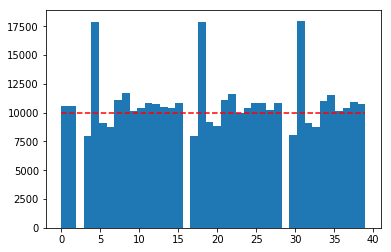

In [8]:

plt.hist(results, bins=40)
avg = len(results) / 40
plt.plot([0, 39], [avg, avg], 'r--');

In [9]:
board[4]

'R3'

In [10]:

def P(pred, dst): 
    "Proba that pred is true, given the dst pdf"
    return sum(dst[e] for e in dst if pred(e))

class ProbabilityDistribution(dict):
    "A Probability Distribution; an {outcome: probability} mapping where probabilities sum to 1."
    def __init__(self, mapping=(), **kwargs):
        self.update(mapping, **kwargs)
        total = sum(self.values())
        if isinstance(total, int): 
            total = Fraction(total, 1)
        for key in self: # Make probabilities sum to 1.
            self[key] = self[key] / total
            
    def __and__(self, pred): # Call this method by writing ProbabilityDistribution & predicate
        "New ProbabilityDistribution, for outcomes of this ProbabilityDistribution for which pred is true."
        return ProbabilityDistribution({e:self[e] for e in self if pred(e)})

def Uniform(out): return ProbabilityDistribution({e: 1 for e in out})

def joint(X, Y, sep=''):
    "joint pdf of two independent pdfs. Entries of the shape {x+sep+y: P(x)*P(y)}"
    return ProbabilityDistribution({x + sep + y: X[x] * Y[y]
                    for x in X
                    for y in Y})

In [11]:
probD = ProbabilityDistribution(Counter(board[i] for i in results))
probD

{'R3': Fraction(17907, 400000),
 'R7': Fraction(5847, 200000),
 'R8': Fraction(10831, 400000),
 'R9': Fraction(269, 10000),
 'R13': Fraction(1789, 40000),
 'R17': Fraction(2331, 80000),
 'R20': Fraction(2161, 80000),
 'R22': Fraction(2009, 100000),
 'R25': Fraction(8789, 400000),
 'R28': Fraction(1013, 40000),
 'Swamp': Fraction(15641, 200000),
 'R29': Fraction(10711, 400000),
 'R2': Fraction(7939, 400000),
 'R5': Fraction(4379, 200000),
 'ZombieVines': Fraction(5099, 100000),
 'R10': Fraction(263, 10000),
 'GarlicGarden': Fraction(18939, 400000),
 'R14': Fraction(9149, 400000),
 'R18': Fraction(4983, 200000),
 'R19': Fraction(339, 12500),
 'R23': Fraction(17987, 400000),
 'R27': Fraction(11549, 400000),
 'GO': Fraction(5271, 200000),
 'DiagonAlley': Fraction(1453, 20000),
 'R12': Fraction(5423, 200000),
 'R16': Fraction(11079, 400000),
 'R26': Fraction(11033, 400000),
 'R1': Fraction(661, 25000),
 'R21': Fraction(10819, 400000),
 'R11': Fraction(10401, 400000),
 'R4': Fraction(9103, 4

Probability of landing on each cell on the game board, notice that player has the most probability of landing on cell 13, 14 (Road 10 & 11) 

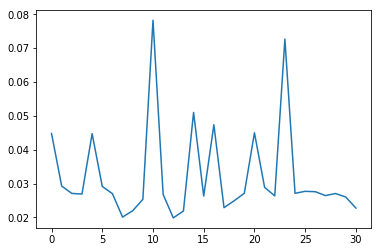

In [12]:
v = [];
for f in probD.values():
    v.append(float(f))
v
plt.plot(v)

Compute the regular transition matrix.

In [13]:
regular = np.zeros((40,40))

In [14]:
dieroll_distance = np.zeros(40)

In [15]:
rolls = [2, 1, 1, 1, 1]
for index, r in enumerate(rolls):
    dieroll_distance[index] = r
dieroll_distance /= 6
print(dieroll_distance)

[0.33333333 0.16666667 0.16666667 0.16666667 0.16666667 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]


In [16]:
for row in range(40):
    regular[row] = np.roll(dieroll_distance, row)
pd.DataFrame(regular)

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,0.333333,0.166667,0.166667,0.166667,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.333333,0.166667,0.166667,0.166667,0.166667,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.333333,0.166667,0.166667,0.166667,0.166667,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.333333,0.166667,0.166667,0.166667,0.166667,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.333333,0.166667,0.166667,0.166667,0.166667,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.166667,0.166667,0.166667,0.166667,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.166667,0.166667,0.166667,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.166667,0.166667,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.166667,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Compute the special transition matrix that takes Car and Swamp cells into consideration


In [17]:
special = np.zeros((40,40))

In [18]:
swamps_i = list_duplicates_of(board,'Swamp')
diagonalleys_i = list_duplicates_of(board,'DiagonAlley')
for c in range(40):
    if c in cars_i:
        special[c,c+3] = 1.0
    elif c in swamps_i:
        special[c,c] = 1
    elif c in diagonalleys_i:
        special[c,c+1] = 1/2
        special[c,c] = 1/2
    else:
        special[c, c] = 1.0
pd.DataFrame(special)

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
transition = regular @ special
pd.DataFrame(transition)


,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,0.333333,0.166667,0.0,0.166667,0.166667,0.166667,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.333333,0.0,0.166667,0.166667,0.333333,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.0,0.166667,0.166667,0.500000,0.166667,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.0,0.333333,0.166667,0.166667,0.166667,0.083333,0.083333,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.0,0.000000,0.333333,0.166667,0.166667,0.083333,0.250000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.0,0.000000,0.000000,0.333333,0.166667,0.083333,0.250000,0.166667,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.333333,0.083333,0.250000,0.166667,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.166667,0.333333,0.166667,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.166667,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [20]:
for i in range(40):
    print(np.sum(transition[i]))

1.0
1.0
0.9999999999999999
0.9999999999999999
1.0
0.9999999999999999
0.9999999999999999
0.9999999999999999
0.9999999999999999
1.0
1.0
1.0
0.9999999999999999
1.0
1.0
1.0
0.9999999999999999
1.0
1.0
1.0
0.9999999999999999
1.0
1.0
1.0
0.9999999999999999
0.9999999999999999
1.0
1.0
1.0
1.0
1.0
1.0
0.9999999999999999
1.0
1.0
1.0
0.9999999999999999
1.0
1.0
1.0


In [21]:
w, v = la.eig(transition)

In [22]:
v

array([[ 0.        +0.j,  0.        +0.j,  0.        +0.j, ...,
        -0.10359668+0.j, -0.0017282 +0.j, -0.09247645+0.j],
       [ 0.        +0.j,  0.        +0.j,  0.        +0.j, ...,
         0.05049524+0.j, -0.01206354+0.j,  0.1494406 +0.j],
       [ 1.        +0.j,  0.        +0.j,  0.        +0.j, ...,
        -0.04602043+0.j, -0.20672447+0.j,  0.21233705+0.j],
       ...,
       [ 0.        +0.j,  0.        +0.j,  0.        +0.j, ...,
        -0.10362264+0.j, -0.04506818+0.j,  0.31940017+0.j],
       [ 0.        +0.j,  0.        +0.j,  0.        +0.j, ...,
         0.05054715+0.j,  0.0250717 +0.j, -0.0875339 +0.j],
       [ 0.        +0.j,  0.        +0.j,  0.        +0.j, ...,
         0.07163524+0.j,  0.00951672+0.j, -0.08608212+0.j]])

In [23]:
w2, v2 = la.eig(transition)
w2

array([0.        +0.j        , 0.        +0.j        ,
       0.        +0.j        , 1.        +0.j        ,
       0.92405005+0.27725517j, 0.92405005-0.27725517j,
       0.72615653+0.46896933j, 0.72615653-0.46896933j,
       0.48033756+0.52880989j, 0.48033756-0.52880989j,
       0.26670566+0.46582709j, 0.26670566-0.46582709j,
       0.13737449+0.32984116j, 0.13737449-0.32984116j,
       0.1010537 +0.18796469j, 0.1010537 -0.18796469j,
       0.32735151+0.11504644j, 0.32735151-0.11504644j,
       0.26098497+0.14248803j, 0.26098497-0.14248803j,
       0.35607121+0.05120042j, 0.35607121-0.05120042j,
       0.18554501+0.11837991j, 0.18554501-0.11837991j,
       0.1141502 +0.07607977j, 0.1141502 -0.07607977j,
       0.13293198+0.05130043j, 0.13293198-0.05130043j,
       0.32615857+0.00979771j, 0.32615857-0.00979771j,
       0.14534688+0.00549574j, 0.14534688-0.00549574j,
       0.16666667+0.j        , 0.2664358 +0.0483954j ,
       0.2664358 -0.0483954j , 0.20712339+0.00929276j,
       0.2

Dominant eigenvector

In [24]:
dominant = v[0]
pd.DataFrame(np.abs(v[0]))

,0
0,0.000000e+00
1,0.000000e+00
2,0.000000e+00
3,1.581139e-01
4,1.584803e-01
5,1.584803e-01
6,1.593418e-01
7,1.593418e-01
8,1.598053e-01
9,1.598053e-01


In [25]:
norm = np.sum(np.abs(v[0]))
norm

4.529174091847109

Construct object-oriented program for the IOB game


In [26]:
NUM_CELLS = 40
dieset = [1,2,3,4,'Gun','Med']

Zombies object

In [115]:
class Zombies(object):
    
    def __init__(self, game):
        self.v_zombies = 2
        self.power = 15
        self.position = 0
        self.round = 1
        self.turn = 0
        self.game = game
        self.shot = False
        
    def goto_action(self, pass_go = True, isNight = False):
        move = True
        bite = False
        if self.shot == True:
            return False,False
        if pass_go:
            closest = self.v_zombies
            for p in self.game.players:
                if p.position - self.position < closest:
                    closest = p.position - self.position
            if self.position + closest == self.position: #Zombies can not pass by the player
                move = False
            self.position = self.position + closest
            print('zombies() position: ',self.position)
            self.turn += 1
            print('list at Zombies() position: ',game.gameBoard[self.position])
            if game.boardTemplate[self.position] != 'GarlicGarden':
                for x in game.gameBoard[self.position]: #In GarlicGarden, Zombies can not attack players
        
                    if isinstance(x,Player):
                        print('bite?')
                        bite = True
                        x.hp = x.hp - self.power
                        
        print('zombies move?', move)
        return move, bite

Player object

In [116]:
class Player(object):
    
    def __init__(self, playerNum, game):
        self.playerNum = playerNum
        self.game = game
        self.position = 0
        self.turn = 0
        self.round = 1
        self.score = 0
        self.hp = 100
        self.bitten_cnt = 0
        self.death_cnt = 0
        
    def roll_dice(self):
        die = random.choice(dieset)
        return die
    def goto_action(self,die,pass_go = True):
        self.turn += 1
        gunshot = False
        new_round = False
        isDrive = False
        self.die = die
        if isinstance(die, int):
            
            self.position += die
            
        elif die == 'Gun': 
            for l in self.game.gameBoard[self.position-2:self.position+1]:
                for x in l:
                    if isinstance(x, Zombies):
                        self.score += 2
                        gunshot = True
                        break    #Only if the distance between Zombies and Players is less than 2, players are able to shoot.
        else:
            if self.hp != 100:
                self.hp  = (100 if self.hp + 5 > 100 else self.hp + 5)
        
        if self.position >= NUM_CELLS:
                self.position = self.position % NUM_CELLS
                self.round += 1
                new_round = True
        
        print('??????????',self.game.boardTemplate[self.position])
        if self.game.boardTemplate[self.position] == 'Car':
            isDrive = True
            print('drive car??????????')# When players stand on the car, they wiil be forced two cells automatically.
            self.position += 2
        return new_round, self.position, gunshot, isDrive
        

Create game board based on the board template created at the very begining 

Let's define the game board with properties 

In [117]:
properties = [['Go','White',0,0],['1','None',0,0],['1','None',0,0], ['Car','Green',0,0], ['2','None',0,0], ['3','None',0,0], ['4','None',0,0],['5','None',0,0],
             ['Diagon Alley','Red',0,0], ['6','None',0,0], ['Zombie Vines','Blue',0,0], ['Swamp','Yellow',0,0], ['7','None',0,0], ['8','None',0,0],
             ['9','None',0,0], ['10','None',0,0], ['11','None',0,0], ['Car','Green',0,0], ['Garlic Garden','Golden',0,0], ['12','None',0,0], ['13','None',0,0],
             ['Diagon Alley','Red',0,0], ['14','None',0,0], ['15','None',0,0], ['16','None',0,0], ['Swamp','Yellow',0,0], ['17','None',0,0], ['18','None',0,0],
             ['Zombie Vines','Blue',0,0], ['19','None',0,0], ['Car','Green',0,0], ['20','None',0,0], ['21','None',0,0], ['Diagon Alley','Red',0,0], ['22','None',0,0],
             ['23','None',0,0], ['24','None',0,0], ['25','None',0,0],['Swamp','Yellow',0,0], ['Garlic Garden','Golden',0,0], ['26','None',0,0]]


In [109]:
Property = namedtuple('Property',['Name','Color','Death','Bite'])

In [101]:
properties = [
            Property('Go','White',0,0),
            Property('1','None',0,0),
            Property('Car','Green',0,0),
            Property('2','None',0,0),
            Property('3','None',0,0),
            Property('4','None',0,0),
            Property('5','None',0,0),
            Property('Diagon Alley','Red',0,0),
            Property('6','None',0,0),
            Property('Zombie Vines','Blue',0,0),
            Property('Swamp','Yellow',0,0),
            Property('7','None',0,0),
            Property('8','None',0,0),
            Property('9','None',0,0),
            Property('10','None',0,0),
            Property('11','None',0,0),
            Property('Car','Green',0,0),
            Property('Garlic Garden','Golden',0,0),
            Property('12','None',0,0),
            Property('13','None',0,0),
            Property('Diagon Alley','Red',0,0),
            Property('14','None',0,0),
            Property('15','None',0,0),
            Property('16','None',0,0),
            Property('Swamp','Yellow',0,0),
            Property('17','None',0,0),
            Property('18','None',0,0),
            Property('Zombie Vines','Blue',0,0),
            Property('19','None',0,0),
            Property('Car','Green',0,0),
            Property('20','None',0,0),
            Property('21','None',0,0),
            Property('Diagon Alley','Red',0,0),
            Property('22','None',0,0),
            Property('23','None',0,0),
            Property('24','None',0,0),
            Property('25','None',0,0),
            Property('Swamp','Yellow',0,0),
            Property('Garlic Garden','Golden',0,0),
            Property('26','None',0,0)       
        ]

`results` is a list where each element is a list of player positional information (state)

In [118]:
results = []

Let's define the Game object:

In [126]:
class Game():
    def __init__(self, numPlayers, properties):
        self.gameBoard = []
        for _ in range(NUM_CELLS):
            self.gameBoard.append([None])
        self.boardTemplate = """GO   R1 Car  R2  R3 R4 R5  DiagonAlley R7 ZombieVines
           Swamp R8 R9  R10  R11 R12 Car  GarlicGarden R13 R14 
           DiagonAlley   R16 R17 R18  Swamp R19 R20  ZombieVines  R21 Car 
           R22  R23 DiagonAlley  R25 R26 R27 R28 Swamp  GarlicGarden R29""".split()
        self.players = [Player(i + 1, self) for i in range(numPlayers)]
        self.gameBoard[0] = self.players.copy()
        self.zombies = Zombies(self)
        self.diagonalleyCards = ['key','loss']
        random.shuffle(self.diagonalleyCards)
        self.Properties = properties
        self.round = 0
  
    def playIOB(self, num_rolls):
        day_cnt = 0
        night_cnt = 0
        
        for r in range(num_rolls):
            
            for p in self.players:
                die = p.roll_dice()
                print('???????????????', die)
                nr, player_pos, gunshot, isDrive = p.goto_action(die)
                self.zombies.shot = True if gunshot else False
                if isinstance(die,int):
                    print('ppos: ', p.position)
                    print("Player current roll: ", die)
                    print('gameboard at ppos - die: ', self.gameBoard[p.position-die])
                    if isDrive:
                        (self.gameBoard[p.position-die-2]).remove(p)
                    else:
                        (self.gameBoard[p.position-die]).remove(p)
                    if isDrive:
                        if len(self.gameBoard[p.position-die-2]) == 0:
                            self.gameBoard[p.position-die - 2].append(None)
                    else:
                        if len(self.gameBoard[p.position-die]) == 0:
                            self.gameBoard[p.position-die].append(None)
                    if self.gameBoard[p.position] == [None]:
                        self.gameBoard[p.position] = [p]
                    else:
                        self.gameBoard[p.position].append(p)
                else:
                    print('player did not move')
                new_round = nr
               
                print("Player current roll: ", die)
                print("Player current possition: ", p.position)
                print("Player current score: ", p.score)
                print("Player current hp: ", p.hp)
                print("Total number of rolls: ", p.turn)
                print("player round: ", p.round)
                self.round = p.round
                results.append([
                             p.turn, 
                            p.playerNum,
                            die,
                            p.hp,
                            p.position,
                            p.bitten_cnt,
                            p.death_cnt])

                
            # properties[p.position].Name])
            if new_round:
                self.zombies = Zombies(self)
                for i in range(len(self.gameBoard)-1,-1,-1):
                    if isinstance(self.gameBoard[i][0],Zombies):
                        self.gameBoard[i][0] = None
                        break
            if self.players[0].position >= 4:
                print('zombies.turn',self.zombies.turn)
                if day_cnt == 5 and self.zombies.turn != 0 and night_cnt < 2:
                    self.zombies.power = 30
                    self.zombies.v_zombies = 3
                    if self.boardTemplate[self.zombies.position] == 'ZomebieVines':
                        self.zombies.goto_action(pass_go = False, isNight = True)
                    else:
                        z_prevPos = self.zombies.position
                        z_move, z_bite = self.zombies.goto_action(pass_go = True, isNight = True)
                        print('zomebies move? ', z_move)
                        if z_move:
                            self.gameBoard[z_prevPos] = [None]
                            if self.gameBoard[self.zombies.position] == [None]:
                                self.gameBoard[self.zombies.position] = [self.zombies]
                            else:
                                self.gameBoard[self.zombies.position].append(self.zombies)
                    night_cnt += 1
                    day_cnt = 0 if night_cnt == 2 else 5
                else:
                    self.zombies.power = 5
                    self.zombies.v_zombies = 2
                    if self.boardTemplate[self.zombies.position] == 'ZomebieVines':
                        self.zombies.goto_action(pass_go = False, isNight = False)
                    else:
                        z_prevPos = self.zombies.position
                        z_move, z_bite = self.zombies.goto_action(pass_go = True, isNight = False)
                        print('zomebies move? ', z_move)
                        if z_move:
                            self.gameBoard[z_prevPos] = [None]
                            if self.gameBoard[self.zombies.position] == [None]:
                                print('overwrite?')
                                self.gameBoard[self.zombies.position] = [self.zombies]
                            else:
                                print('append?')
                                self.gameBoard[self.zombies.position].append(self.zombies)
                    day_cnt += 1
                    night_cnt = 0
                
                
                if z_bite:
                    for x in self.gameBoard[self.zombies.position]:
                        if isinstance(x, Player):
                            # col 4 is bite count
                            x.bitten_cnt += 1
                            self.Properties[self.zombies.position][-1] += 1
                            if x.hp <= 0:
                                print('哎哟我去')
                                x.death_cnt += 1
                                self.Properties[self.zombies.position][-2] += 1
                                x.hp = 100
                            
                           
                                
                    
            print("Night? ", day_cnt ==5)
            print('Zomebies speed and power: ', self.zombies.v_zombies, self.zombies.power)
            print("Zombies current position: ", self.zombies.position)
            print("Player current hp: ", p.hp)
            print('gameboard at ppos - die: ', self.gameBoard[p.position])
            print("Current gameboard:")
            print(game.gameBoard)
            print("---------------------------------------------------")
        return results    

Let's play some games!

In [127]:
game = Game(1,properties)
results = game.playIOB(1000)

??????????????? 2
?????????? Car
drive car??????????
ppos:  4
Player current roll:  2
gameboard at ppos - die:  [None]
Player current roll:  2
Player current possition:  4
Player current score:  0
Player current hp:  100
Total number of rolls:  1
player round:  1
zombies.turn 0
zombies() position:  2
list at Zombies() position:  [None]
zombies move? True
zomebies move?  True
overwrite?
Night?  False
Zomebies speed and power:  2 5
Zombies current position:  2
Player current hp:  100
gameboard at ppos - die:  [<__main__.Player object at 0x61afcbb70>]
Current gameboard:
[[None], [None], [<__main__.Zombies object at 0x61afcbcf8>], [None], [<__main__.Player object at 0x61afcbb70>], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None]]
----------------------------------

zomebies move?  False
Night?  False
Zomebies speed and power:  2 5
Zombies current position:  33
Player current hp:  100
gameboard at ppos - die:  [<__main__.Player object at 0x61afcbb70>]
Current gameboard:
[[None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [<__main__.Zombies object at 0x61b7beac8>], [None], [<__main__.Player object at 0x61afcbb70>], [None], [None], [None], [None]]
---------------------------------------------------
??????????????? 4
?????????? R29
ppos:  39
Player current roll:  4
gameboard at ppos - die:  [<__main__.Player object at 0x61afcbb70>]
Player current roll:  4
Player current possition:  39
Player current score:  10
Player current hp:  100
Total number of rolls:  46
player round:  2
zombies.turn 17
zombies() position:  35
list at Zombies() positio

player round:  4
zombies.turn 7
zombies() position:  16
list at Zombies() position:  [None]
zombies move? True
zomebies move?  True
overwrite?
Night?  False
Zomebies speed and power:  2 5
Zombies current position:  16
Player current hp:  100
gameboard at ppos - die:  [<__main__.Player object at 0x61afcbb70>]
Current gameboard:
[[None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [<__main__.Zombies object at 0x61b8d7e80>], [None], [None], [None], [None], [None], [<__main__.Player object at 0x61afcbb70>], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None]]
---------------------------------------------------
??????????????? Med
?????????? R17
player did not move
Player current roll:  Med
Player current possition:  22
Player current score:  18
Player current hp:  100
Total number of rolls:  81
player round:  4
zombies.turn 8
zombies

list at Zombies() position:  [None]
zombies move? True
zomebies move?  True
overwrite?
Night?  False
Zomebies speed and power:  2 5
Zombies current position:  4
Player current hp:  95
gameboard at ppos - die:  [<__main__.Player object at 0x61afcbb70>]
Current gameboard:
[[None], [None], [None], [None], [<__main__.Zombies object at 0x61b91f080>], [None], [None], [None], [<__main__.Player object at 0x61afcbb70>], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None]]
---------------------------------------------------
??????????????? 3
?????????? R8
ppos:  11
Player current roll:  3
gameboard at ppos - die:  [<__main__.Player object at 0x61afcbb70>]
Player current roll:  3
Player current possition:  11
Player current score:  24
Player current hp:  95
Total number of rolls:  115
player round:  6
zom

Player current hp:  85
gameboard at ppos - die:  [<__main__.Player object at 0x61afcbb70>]
Current gameboard:
[[None], [None], [<__main__.Zombies object at 0x61ba767f0>], [None], [<__main__.Player object at 0x61afcbb70>], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None]]
---------------------------------------------------
??????????????? 1
?????????? R4
ppos:  5
Player current roll:  1
gameboard at ppos - die:  [<__main__.Player object at 0x61afcbb70>]
Player current roll:  1
Player current possition:  5
Player current score:  32
Player current hp:  85
Total number of rolls:  160
player round:  8
zombies.turn 1
zombies() position:  4
list at Zombies() position:  [None]
zombies move? True
zomebies move?  True
overwrite?
Night?  False
Zomebies speed and power:  

Player current score:  36
Player current hp:  80
Total number of rolls:  205
player round:  10
zombies.turn 2
zombies() position:  6
list at Zombies() position:  [None]
zombies move? True
zomebies move?  True
overwrite?
Night?  False
Zomebies speed and power:  2 5
Zombies current position:  6
Player current hp:  80
gameboard at ppos - die:  [<__main__.Player object at 0x61afcbb70>]
Current gameboard:
[[None], [None], [None], [None], [None], [None], [<__main__.Zombies object at 0x61ba76748>], [None], [None], [None], [None], [<__main__.Player object at 0x61afcbb70>], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None]]
---------------------------------------------------
??????????????? Med
?????????? R8
player did not move
Player current roll:  Med
Player current possition:  11
Player current score:  36
Player current h

Player current roll:  4
Player current possition:  31
Player current score:  44
Player current hp:  90
Total number of rolls:  239
player round:  11
zombies.turn 12
zombies() position:  26
list at Zombies() position:  [None]
zombies move? True
zomebies move?  True
overwrite?
Night?  False
Zomebies speed and power:  2 5
Zombies current position:  26
Player current hp:  90
gameboard at ppos - die:  [<__main__.Player object at 0x61afcbb70>]
Current gameboard:
[[None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [<__main__.Zombies object at 0x61b918048>], [None], [None], [None], [None], [<__main__.Player object at 0x61afcbb70>], [None], [None], [None], [None], [None], [None], [None], [None]]
---------------------------------------------------
??????????????? 3
?????????? R26
ppos:  34
Player current roll:  3
gameboard at ppos - die:  [<

overwrite?
Night?  False
Zomebies speed and power:  2 5
Zombies current position:  29
Player current hp:  70
gameboard at ppos - die:  [<__main__.Player object at 0x61afcbb70>]
Current gameboard:
[[None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [<__main__.Zombies object at 0x61b91f7f0>], [None], [<__main__.Player object at 0x61afcbb70>], [None], [None], [None], [None], [None], [None], [None], [None]]
---------------------------------------------------
??????????????? 3
?????????? R26
ppos:  34
Player current roll:  3
gameboard at ppos - die:  [<__main__.Player object at 0x61afcbb70>]
Player current roll:  3
Player current possition:  34
Player current score:  50
Player current hp:  70
Total number of rolls:  284
player round:  13
zombies.turn 15
zombies() position:  31
list at Zombies() position:  [None]


zombies move? True
zomebies move?  True
append?
Night?  False
Zomebies speed and power:  2 5
Zombies current position:  6
Player current hp:  85
gameboard at ppos - die:  [<__main__.Player object at 0x61afcbb70>, <__main__.Zombies object at 0x61b4dcd30>]
Current gameboard:
[[None], [None], [None], [None], [None], [None], [<__main__.Player object at 0x61afcbb70>, <__main__.Zombies object at 0x61b4dcd30>], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None]]
---------------------------------------------------
??????????????? 2
?????????? R7
ppos:  8
Player current roll:  2
gameboard at ppos - die:  [<__main__.Player object at 0x61afcbb70>, <__main__.Zombies object at 0x61b4dcd30>]
Player current roll:  2
Player current possition:  8
Player current score:  52
Player current hp:  85

Zombies current position:  14
Player current hp:  85
gameboard at ppos - die:  [<__main__.Player object at 0x61afcbb70>]
Current gameboard:
[[None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [<__main__.Zombies object at 0x61bbd5588>], [None], [None], [None], [None], [None], [None], [<__main__.Player object at 0x61afcbb70>], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None]]
---------------------------------------------------
??????????????? Med
?????????? R16
player did not move
Player current roll:  Med
Player current possition:  21
Player current score:  60
Player current hp:  90
Total number of rolls:  363
player round:  17
zombies.turn 7
zombies() position:  16
list at Zombies() position:  [None]
zombies move? True
zomebies move?  True
overwrite?
Night?  False
Zomebies speed and power:  2 5
Zombies current position:  16
Player cu

Current gameboard:
[[None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [<__main__.Zombies object at 0x61b918908>], [None], [None], [None], [None], [None], [None], [None], [None], [None], [<__main__.Player object at 0x61afcbb70>]]
---------------------------------------------------
??????????????? Gun
?????????? R29
player did not move
Player current roll:  Gun
Player current possition:  39
Player current score:  68
Player current hp:  85
Total number of rolls:  398
player round:  18
zombies.turn 16
zombies() position:  31
list at Zombies() position:  [None]
zombies move? True
zomebies move?  True
overwrite?
Night?  False
Zomebies speed and power:  2 5
Zombies current position:  31
Player current hp:  85
gameboard at ppos - die:  [<__main__.Player object at 0x61afcbb70>]
Current gameboard:
[[None], [None], [N

Current gameboard:
[[None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [<__main__.Player object at 0x61afcbb70>, <__main__.Zombies object at 0x61bc02be0>], [None], [None], [None], [None], [None], [None], [None], [None]]
---------------------------------------------------
??????????????? 1
?????????? DiagonAlley
ppos:  32
Player current roll:  1
gameboard at ppos - die:  [<__main__.Player object at 0x61afcbb70>, <__main__.Zombies object at 0x61bc02be0>]
Player current roll:  1
Player current possition:  32
Player current score:  72
Player current hp:  85
Total number of rolls:  421
player round:  19
zombies.turn 18
zombies() position:  32
list at Zombies() position:  [<__main__.Player object at 0x61afcbb70>]
bite?
zombies move? True
zomebies move?  True
append?
Night?  False
Zomebies speed and

Player current score:  80
Player current hp:  75
Total number of rolls:  462
player round:  21
zombies.turn 11
zombies() position:  22
list at Zombies() position:  [None]
zombies move? True
zomebies move?  True
overwrite?
Night?  False
Zomebies speed and power:  2 5
Zombies current position:  22
Player current hp:  75
gameboard at ppos - die:  [<__main__.Player object at 0x61afcbb70>]
Current gameboard:
[[None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [<__main__.Zombies object at 0x61bbd5208>], [None], [None], [None], [None], [<__main__.Player object at 0x61afcbb70>], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None]]
---------------------------------------------------
??????????????? Med
?????????? ZombieVines
player did not move
Player current roll:  Med
Player current possition:  27
Player current score:  80
Play

zomebies move?  True
overwrite?
Night?  False
Zomebies speed and power:  2 5
Zombies current position:  14
Player current hp:  80
gameboard at ppos - die:  [<__main__.Player object at 0x61afcbb70>]
Current gameboard:
[[None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [<__main__.Zombies object at 0x61bcc9550>], [None], [None], [None], [<__main__.Player object at 0x61afcbb70>], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None]]
---------------------------------------------------
??????????????? Gun
?????????? R13
player did not move
Player current roll:  Gun
Player current possition:  18
Player current score:  86
Player current hp:  80
Total number of rolls:  500
player round:  23
zombies.turn 8
zombies() position:  16
list at Zombies() position:  [None]
zombies move? True
zomebies move?  True
overwrite?
Night? 

zombies move? True
zomebies move?  True
overwrite?
Night?  False
Zomebies speed and power:  2 5
Zombies current position:  6
Player current hp:  70
gameboard at ppos - die:  [<__main__.Player object at 0x61afcbb70>]
Current gameboard:
[[None], [None], [None], [None], [None], [None], [<__main__.Zombies object at 0x61b91f0b8>], [None], [<__main__.Player object at 0x61afcbb70>], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None]]
---------------------------------------------------
??????????????? 1
?????????? ZombieVines
ppos:  9
Player current roll:  1
gameboard at ppos - die:  [<__main__.Player object at 0x61afcbb70>]
Player current roll:  1
Player current possition:  9
Player current score:  92
Player current hp:  70
Total number of rolls:  523
player round:  24
zombies.turn 3
zombies() positi

gameboard at ppos - die:  [<__main__.Player object at 0x61afcbb70>]
Current gameboard:
[[None], [None], [None], [None], [None], [None], [None], [None], [<__main__.Zombies object at 0x61ba76e80>], [None], [<__main__.Player object at 0x61afcbb70>], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None]]
---------------------------------------------------
??????????????? 4
?????????? R11
ppos:  14
Player current roll:  4
gameboard at ppos - die:  [<__main__.Player object at 0x61afcbb70>]
Player current roll:  4
Player current possition:  14
Player current score:  94
Player current hp:  75
Total number of rolls:  545
player round:  25
zombies.turn 4
zombies() position:  10
list at Zombies() position:  [None]
zombies move? True
zomebies move?  True
overwrite?
Night?  False
Zomebies speed and power:  2 5
Zombies curren

Player current possition:  22
Player current score:  94
Player current hp:  90
Total number of rolls:  589
player round:  27
zombies.turn 9
zombies() position:  20
list at Zombies() position:  [None]
zombies move? True
zomebies move?  True
overwrite?
Night?  False
Zomebies speed and power:  2 5
Zombies current position:  20
Player current hp:  90
gameboard at ppos - die:  [<__main__.Player object at 0x61afcbb70>]
Current gameboard:
[[None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [<__main__.Zombies object at 0x61bd5d208>], [None], [<__main__.Player object at 0x61afcbb70>], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None]]
---------------------------------------------------
??????????????? Gun
?????????? R17
player did not move
Player current roll:  Gun
Player current possition:  22
Player cu

ppos:  0
Player current roll:  2
gameboard at ppos - die:  [<__main__.Player object at 0x61afcbb70>, <__main__.Zombies object at 0x61ba76e80>]
Player current roll:  2
Player current possition:  0
Player current score:  110
Player current hp:  70
Total number of rolls:  633
player round:  29
Night?  False
Zomebies speed and power:  2 15
Zombies current position:  0
Player current hp:  70
gameboard at ppos - die:  [<__main__.Player object at 0x61afcbb70>]
Current gameboard:
[[<__main__.Player object at 0x61afcbb70>], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None]]
---------------------------------------------------
??????????????? 2
?????????? Car
drive car??????????
ppos:  4
Player current roll:  2
gameboard at ppos - die:  [No

zombies.turn 15
zombies() position:  32
list at Zombies() position:  [None]
zombies move? True
zomebies move?  True
overwrite?
Night?  False
Zomebies speed and power:  2 5
Zombies current position:  32
Player current hp:  85
gameboard at ppos - die:  [<__main__.Player object at 0x61afcbb70>]
Current gameboard:
[[None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [<__main__.Zombies object at 0x61bcc9da0>], [None], [None], [None], [None], [None], [<__main__.Player object at 0x61afcbb70>], [None]]
---------------------------------------------------
??????????????? 2
?????????? GO
ppos:  0
Player current roll:  2
gameboard at ppos - die:  [<__main__.Player object at 0x61afcbb70>]
Player current roll:  2
Player current possition:  0
Player current score:  112
Player current hp:  85
Total nu

player round:  32
zombies.turn 10
zombies() position:  18
list at Zombies() position:  [None]
zombies move? True
zomebies move?  True
overwrite?
Night?  False
Zomebies speed and power:  2 5
Zombies current position:  18
Player current hp:  85
gameboard at ppos - die:  [<__main__.Player object at 0x61afcbb70>]
Current gameboard:
[[None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [<__main__.Zombies object at 0x61b91f4e0>], [<__main__.Player object at 0x61afcbb70>], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None]]
---------------------------------------------------
??????????????? 4
?????????? R18
ppos:  23
Player current roll:  4
gameboard at ppos - die:  [<__main__.Player object at 0x61afcbb70>]
Player current roll:  4
Player current possition:  23
Player current score:  116
Player cur

Player current score:  122
Player current hp:  85
Total number of rolls:  748
player round:  34
zombies.turn 7
zombies() position:  16
list at Zombies() position:  [None]
zombies move? True
zomebies move?  True
overwrite?
Night?  False
Zomebies speed and power:  2 5
Zombies current position:  16
Player current hp:  85
gameboard at ppos - die:  [<__main__.Player object at 0x61afcbb70>]
Current gameboard:
[[None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [<__main__.Zombies object at 0x61b01d400>], [None], [<__main__.Player object at 0x61afcbb70>], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None]]
---------------------------------------------------
??????????????? Med
?????????? R13
player did not move
Player current roll:  Med
Player current possition:  18
Player current score:  122
Player curr

Zomebies speed and power:  2 5
Zombies current position:  14
Player current hp:  75
gameboard at ppos - die:  [<__main__.Player object at 0x61afcbb70>]
Current gameboard:
[[None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [<__main__.Zombies object at 0x61b01db38>], [None], [None], [None], [<__main__.Player object at 0x61afcbb70>], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None]]
---------------------------------------------------
??????????????? 1
?????????? R14
ppos:  19
Player current roll:  1
gameboard at ppos - die:  [<__main__.Player object at 0x61afcbb70>]
Player current roll:  1
Player current possition:  19
Player current score:  128
Player current hp:  75
Total number of rolls:  786
player round:  36
zombies.turn 7
zombies() position:  16
list at Zombies() position:  [None]
zombies move? True
zomebi

Night?  False
Zomebies speed and power:  2 5
Zombies current position:  10
Player current hp:  95
gameboard at ppos - die:  [<__main__.Player object at 0x61afcbb70>, <__main__.Zombies object at 0x61bcd2630>]
Current gameboard:
[[None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [<__main__.Player object at 0x61afcbb70>, <__main__.Zombies object at 0x61bcd2630>], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None]]
---------------------------------------------------
??????????????? 3
?????????? R10
ppos:  13
Player current roll:  3
gameboard at ppos - die:  [<__main__.Player object at 0x61afcbb70>, <__main__.Zombies object at 0x61bcd2630>]
Player current roll:  3
Player current possition:  13
Player current score:  134
Player current hp:  95
Total number of rolls:  828
player round: 

Player current score:  140
Player current hp:  75
Total number of rolls:  861
player round:  39
zombies.turn 19
zomebies move?  False
Night?  False
Zomebies speed and power:  2 5
Zombies current position:  33
Player current hp:  75
gameboard at ppos - die:  [<__main__.Player object at 0x61afcbb70>]
Current gameboard:
[[None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [<__main__.Zombies object at 0x61bc02fd0>], [None], [<__main__.Player object at 0x61afcbb70>], [None], [None], [None], [None]]
---------------------------------------------------
??????????????? Gun
?????????? R27
player did not move
Player current roll:  Gun
Player current possition:  35
Player current score:  142
Player current hp:  75
Total number of rolls:  862
player round:  39
zombies.turn 19
zomebies move?

Zombies current position:  21
Player current hp:  75
gameboard at ppos - die:  [<__main__.Player object at 0x61afcbb70>, <__main__.Zombies object at 0x61ba87828>]
Current gameboard:
[[None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [<__main__.Player object at 0x61afcbb70>, <__main__.Zombies object at 0x61ba87828>], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None]]
---------------------------------------------------
??????????????? Med
?????????? R16
player did not move
Player current roll:  Med
Player current possition:  21
Player current score:  156
Player current hp:  80
Total number of rolls:  909
player round:  41
zombies.turn 11
zombies() position:  21
list at Zombies() position:  [<__main__.Player object at 0x61afcbb70>, <__main__.Zombies object at 0x61ba87828>]
bite?
zo

gameboard at ppos - die:  [<__main__.Player object at 0x61afcbb70>, <__main__.Zombies object at 0x61afef710>]
Player current roll:  2
Player current possition:  20
Player current score:  162
Player current hp:  80
Total number of rolls:  955
player round:  43
zombies.turn 9
zombies() position:  20
list at Zombies() position:  [<__main__.Player object at 0x61afcbb70>]
bite?
zombies move? True
zomebies move?  True
append?
Night?  False
Zomebies speed and power:  2 5
Zombies current position:  20
Player current hp:  75
gameboard at ppos - die:  [<__main__.Player object at 0x61afcbb70>, <__main__.Zombies object at 0x61afef710>]
Current gameboard:
[[None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [<__main__.Player object at 0x61afcbb70>, <__main__.Zombies object at 0x61afef710>], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None],

In [128]:
game.round

45

In [122]:
game_results = pd.DataFrame(game.Properties, columns=['Name','Color','Death','Bite'])

In [129]:
game_results

,Name,Color,Death,Bite
0,Go,White,0,0
1,1,None,0,0
2,1,None,0,0
3,Car,Green,0,0
4,2,None,0,9
5,3,None,0,4
6,4,None,0,13
7,5,None,1,9
8,Diagon Alley,Red,1,10
9,6,None,0,13


In [83]:
pprop_bitten= pd.DataFrame({'Count':game_results.groupby(['Position','If_Bitten']).size()}).reset_index()
pprop_bitten['Percent Bitten'] = pprop_bitten['Count'].apply(lambda x: x / pprop_bitten['Count'].sum())
pprop_bitten

,Position,If_Bitten,Count,Percent Bitten
0,0,0,3,0.000273
1,0,1,276,0.025091
2,0,52,3,0.000273
3,0,61,1,0.000091
4,0,63,1,0.000091
5,0,69,2,0.000182
6,0,100,2,0.000182
7,0,145,1,0.000091
8,0,146,3,0.000273
9,0,159,2,0.000182


norm = np.sum(np.abs(v[0]))

norm=4.529174091847109

In [ ]:
Normalized_dominant = np.zeros(40)
for o in range(40):
    Normalized_dominant[o] = np.abs(dominant[o]/norm)
    
pd.DataFrame(Normalized_dominant)

In [ ]:
prop_bitten = np.zeros(40)
prop_bitten = Normalized_dominant/ pprop_bitten['Count']
pd.DataFrame(prop_bitten)

In [ ]:
def temp():
    return True, True
a,b = temp()
a